In [318]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from flash_ansr import get_path, FlashANSRTransformer

In [2]:
ids = {
    'v7.0': 'pw4ppc63',
    'v7.0-mini': '01mhwrpq',
}

In [3]:
runs = {}
histories = {}
for version, run_id in ids.items():
    api = wandb.Api()
    run = api.run(f'psaegert/neural-symbolic-regression/{run_id}')
    runs[version] = run
    histories[version] = [x for x in tqdm(run.scan_history(page_size=100000), total=run.summary['_step'], desc=version)]

v7.0: 1500001it [01:42, 14588.10it/s]                             
v7.0-mini: 1500001it [01:44, 14408.19it/s]                             


In [4]:
data = {}
for version, history in histories.items():
    keys = history[0].keys()
    data[version] = {k: np.array([x[k] for x in history]).astype(float) for k in tqdm(keys, desc=version)}

val_data = {}
for version, d in data.items():
    valid_val_mask = ~np.isnan(d['val_ce_loss'])  # Only includes validation steps where the loss is available
    val_data[version] = {k: v[valid_val_mask] for k, v in d.items()}

v7.0-mini: 100%|██████████| 29/29 [00:06<00:00,  4.17it/s]


In [319]:
model_sizes = {
    model: FlashANSRTransformer.from_config(get_path('configs', model, 'nsr.yaml')).n_params for model in ids.keys()
}

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [242]:
x = np.concatenate([val_data[model]['cumulative_training_pflops'] for model in val_data])
y = np.concatenate([val_data[model]['val_ce_loss'] for model in val_data])

valid_mask = ~np.isnan(x) & ~np.isnan(y)
x = x[valid_mask]
y = y[valid_mask]

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

In [268]:
def scaling_law_log(x, a, b):
    return a - b * x

def scaling_law(x, a, b, c):
    return a / (x ** b) + c

def loss(params, x, y, penalty, log):
    if log:
        x = np.log(x)
        y = np.log(y)
        y_pred = scaling_law_log(x, *params)
    else:
        y_pred = scaling_law(x, *params)
    return -np.mean(y_pred) + penalty * np.mean(np.maximum(y_pred - y, 0)) 

In [297]:
log = True
penalty = 10.0
x0 = [2, -0.1] if log else [2, -0.1, 1]

result = minimize(loss, x0=x0, args=(x, y, penalty, log), method='Nelder-Mead')

result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0475387215436191
             x: [ 4.550e-01  1.133e-01]
           nit: 61
          nfev: 117
 final_simplex: (array([[ 4.550e-01,  1.133e-01],
                       [ 4.549e-01,  1.133e-01],
                       [ 4.549e-01,  1.133e-01]]), array([ 4.754e-02,  4.754e-02,  4.754e-02]))

In [298]:
if log:
    print(f'L = {result.x[0]:.2f} / C^{result.x[1]:.2f}')
    y_pred = np.exp(scaling_law_log(np.log(x), *result.x))
else:
    print(f'L = {result.x[0]:.2f} / C^{result.x[1]:.2f} + {result.x[2]:.2f}')
    y_pred = scaling_law(x, *result.x)

L = 0.45 / C^0.11


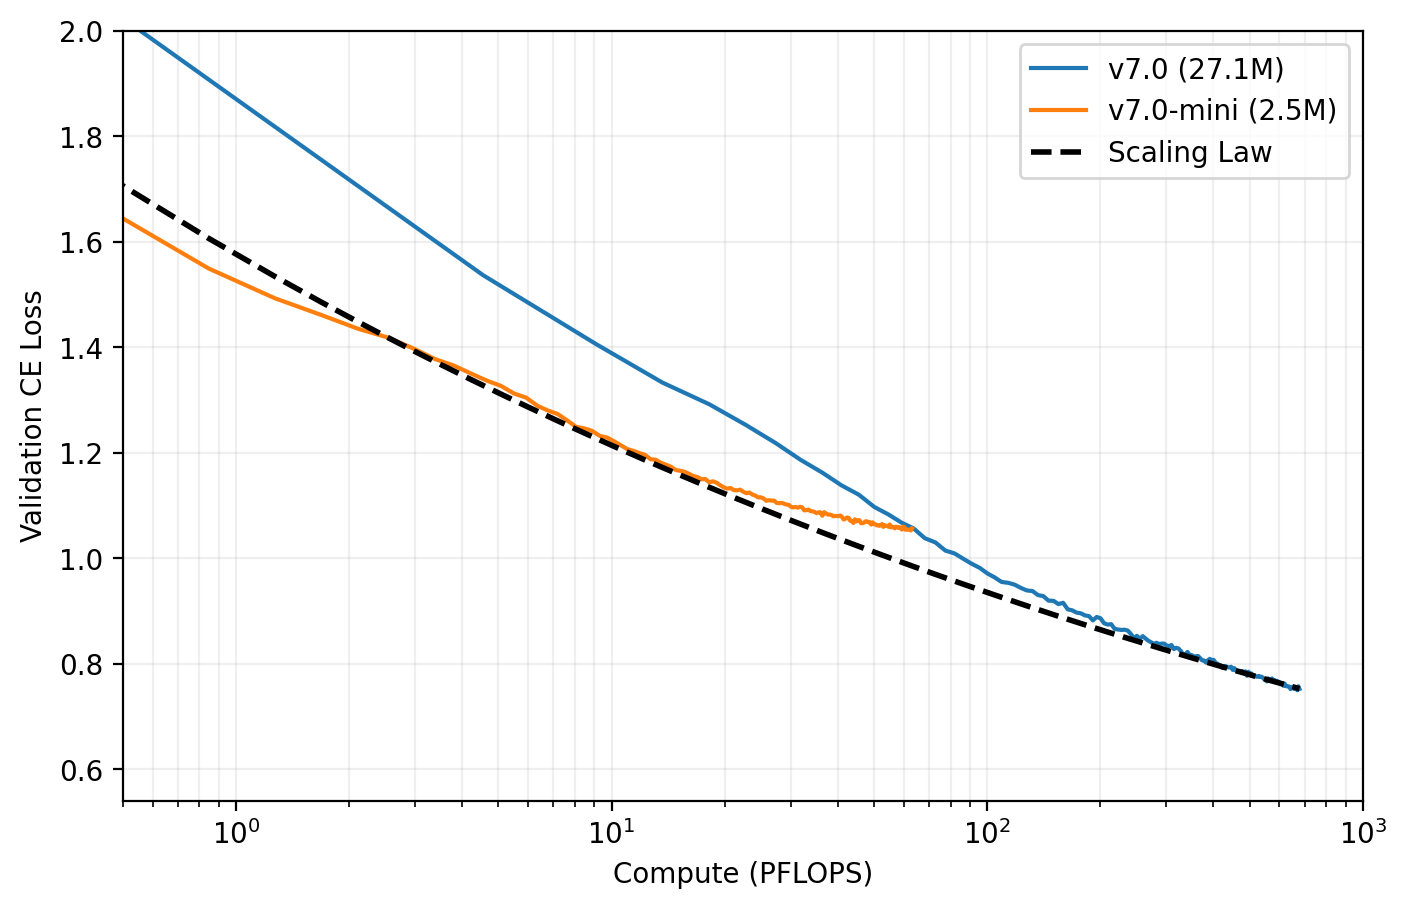

In [324]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

for model in ids.keys():
    ax.plot(val_data[model]['cumulative_training_pflops'], val_data[model]['val_ce_loss'], label=f'{model} ({model_sizes[model] / 1e6:.1f}M)')
ax.plot(x, y_pred, linestyle='--', linewidth=2, color='black', label='Scaling Law')
ax.set_xlabel('Compute (PFLOPS)')
ax.set_ylabel('Validation CE Loss')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(which='both', alpha=0.2)
ax.set_xlim(0.5, 1e3)
ax.set_ylim(None, 2);
ax.legend()

In [313]:
# Compute the compute needed to reach a certain loss
def compute_needed(loss, a, b):
    return np.exp((a - np.log(loss)) / b)

In [317]:
print(f'{compute_needed(0.5, *result.x):,.1f} PFLOPS')

25,146.0 PFLOPS
